In [82]:
import pandas as pd
import numpy as np
import requests
import urllib.parse
from urllib.parse import quote
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta
import seaborn as sns
plt.style.use("ggplot")

#Base URL
base_url = "https://archive-api.open-meteo.com/v1"

In [86]:
citations = pd.read_csv("ParkingCitationsEncrypted.csv")
#We will analyze all the data from Winter Semester 2014 - the end Summer Semester of 2023
citations["IssuedDate"] = pd.to_datetime(citations["IssuedDate"])
citations = citations[(citations["IssuedDate"].dt.year >= 2014) & (citations["IssuedDate"] <= "2023-08-17")].sort_values("IssuedDate").reset_index(drop=True).copy()
#Omit the Covid Months: 2020-04 - 2020-08
citations = citations[(citations["IssuedDate"] < "2020-04-01") | (citations["IssuedDate"] > "2020-08-31")].reset_index(drop=True).copy()

In [87]:
len(citations["IssuedDate"])-1

105405

In [88]:
endpoint = f"/archive?latitude=40.2338&longitude=-111.6585&start_date={citations['IssuedDate'].dt.date.values[0].strftime('%Y-%m-%d')}&end_date={citations['IssuedDate'].dt.date.values[len(citations['IssuedDate'])-1].strftime('%Y-%m-%d')}&daily=temperature_2m_max,temperature_2m_min,temperature_2m_mean,rain_sum,snowfall_sum,wind_speed_10m_max&timezone=America%2FDenver"
url = base_url + endpoint

In [89]:
weather_data = pd.DataFrame(requests.get(url).json()["daily"])

In [93]:
weather_data = weather_data.rename(columns={'time': 'IssuedDate'})
weather_data["IssuedDate"] = pd.to_datetime(weather_data["IssuedDate"])
weather_citations = pd.merge(citations, weather_data, how="left")
weather_citations

,Citation,License.Plate.Vin,Fine,Issued,CitationText,Unpaid,Officer,Residence,IssuedDate,IssuedTime,temperature_2m_max,temperature_2m_min,temperature_2m_mean,rain_sum,snowfall_sum,wind_speed_10m_max
0,P2-07405,CA 1PG151X,0,"Jan 06, 2014 08:50 AM",NaN,False,2,CA,2014-01-06,08:50 AM,-3.3,-17.6,-10.5,0.0,0.0,6.8
1,P5-08047,UT 201TUY,30,"Jan 06, 2014 01:00 PM",NaN,False,5,UT,2014-01-06,01:00 PM,-3.3,-17.6,-10.5,0.0,0.0,6.8
2,P5-08046,VA XRW5196,8,"Jan 06, 2014 12:59 PM",NaN,False,5,VA,2014-01-06,12:59 PM,-3.3,-17.6,-10.5,0.0,0.0,6.8
3,P5-08045,NM M7MM42,30,"Jan 06, 2014 12:56 PM",NaN,False,5,NM,2014-01-06,12:56 PM,-3.3,-17.6,-10.5,0.0,0.0,6.8
4,P5-08044,MT 667345A,30,"Jan 06, 2014 12:55 PM",NaN,False,5,MT,2014-01-06,12:55 PM,-3.3,-17.6,-10.5,0.0,0.0,6.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105401,P6-19569,ID 6AVW68,0,"Aug 17, 2023 02:09 PM",NaN,False,6,ID,2023-08-17,02:09 PM,31.1,18.7,24.3,0.6,0.0,12.3
105402,P6-19570,UT 7S02VG,0,"Aug 17, 2023 02:12 PM",NaN,False,6,UT,2023-08-17,02:12 PM,31.1,18.7,24.3,0.6,0.0,12.3
105403,P6-19571,AB 6LP6B40,0,"Aug 17, 2023 02:20 PM",NaN,False,6,AB,2023-08-17,02:20 PM,31.1,18.7,24.3,0.6,0.0,12.3
105404,P6-19573,UT MU9D48,0,"Aug 17, 2023 04:35 PM",NaN,False,6,UT,2023-08-17,04:35 PM,31.1,18.7,24.3,0.6,0.0,12.3


In [97]:
weather_citations_aggregate = pd.merge(weather_citations.groupby("IssuedDate")[["temperature_2m_min", "rain_sum", "snowfall_sum", "wind_speed_10m_max"]].mean().reset_index(),
         weather_citations.groupby("IssuedDate")["Citation"].count().reset_index())
weather_citations_aggregate

,IssuedDate,temperature_2m_min,rain_sum,snowfall_sum,wind_speed_10m_max,Citation
0,2014-01-06,-17.6,0.0,0.00,6.8,23
1,2014-01-07,-11.6,0.0,0.21,5.9,52
2,2014-01-08,-2.6,0.0,2.66,7.9,13
3,2014-01-09,-10.3,0.0,3.92,8.9,3
4,2014-01-10,-4.1,0.0,0.91,7.0,16
...,...,...,...,...,...,...
1951,2023-08-11,17.2,0.0,0.00,15.6,41
1952,2023-08-14,15.1,0.1,0.00,12.4,51
1953,2023-08-15,18.7,0.1,0.00,10.2,56
1954,2023-08-16,18.8,1.3,0.00,8.0,54


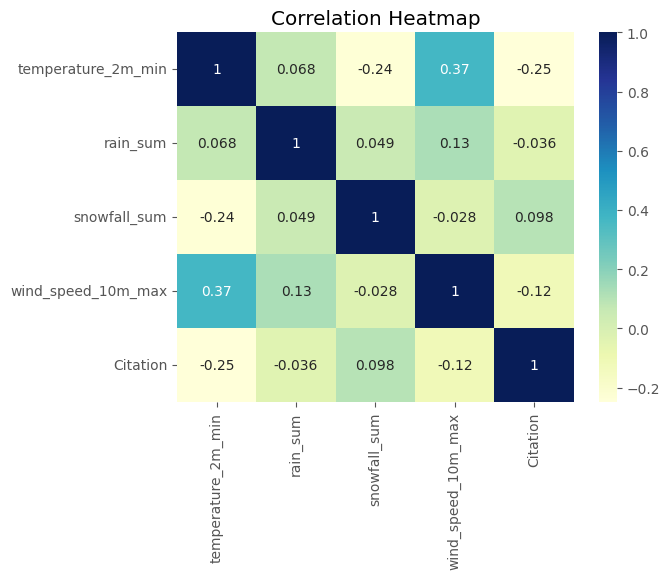

In [99]:
sns.heatmap(weather_citations_aggregate[["temperature_2m_min", "rain_sum", "snowfall_sum", "wind_speed_10m_max", "Citation"]].corr(), cmap="YlGnBu", annot=True)

plt.title("Correlation Heatmap")

plt.show()